# French Motor Claims Datasets

This analysis uses the same features as in the book "Computational Actuarial Science with R" by Arthur Charpentier.

Charpentier Arthur and Katrien Antonio. 2015. Computational Actuarial Science with R. Boca Raton Florida: CRC Press.

In [1]:
import pandas as pd
import tarfile
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_poisson_deviance
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from stabletrees import BaseLineTree,AbuTree,NaiveUpdate,TreeReevaluation,StabilityRegularization, BABUTree
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
SEED = 0
plt.rcParams["figure.figsize"] = (20,12)

In [2]:
path = "..\data\poisson"
for file in os.listdir(path):
    if file.endswith('.csv'):
        name = file.split(".")[0]
        print(name)
        if name == "norauto":
            tar = tarfile.open(path+"//"+name+".tar.gz", "w:gz")
            tar.add(path+"//"+file)
            tar.close()

In [2]:
with tarfile.open("..\data\poisson\\freMTPLfreq.tar.gz", "r:*") as tar:
    csv_path = tar.getnames()[0]
    df = pd.read_csv(tar.extractfile(csv_path), header=0)

In [3]:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

In [4]:
df.head()

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,Frequency
0,1,0,0.09,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0.0
1,2,0,0.84,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0.0
2,3,0,0.52,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0.0
3,4,0,0.45,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0.0
4,5,0,0.15,g,0,41,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,60,0.0


In [ ]:
df["ClaimNb"].sum()/df["Exposure"].sum()

In [98]:
df["DriverAge_binned"]  = pd.cut(df.DriverAge , bins=[17,22,26,42,74,np.inf])

In [112]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
poisson_model = smf.poisson("ClaimNb~DriverAge_binned",offset = np.log(df["Exposure"]), data = df)
result = poisson_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.164571
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                ClaimNb   No. Observations:               413169
Model:                        Poisson   Df Residuals:                   413164
Method:                           MLE   Df Model:                            4
Date:                Wed, 03 May 2023   Pseudo R-squ.:                0.006420
Time:                        11:31:07   Log-Likelihood:                -67996.
converged:                       True   LL-Null:                       -68435.
Covariance Type:            nonrobust   LLR p-value:                7.016e-189
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                   -1.6634      0.034    -49.427      0.000      -1.729      -1.597
DriverAge_binned[T.Interval(22.0, 26.0, closed='right')]    -0.5694      0.046    -12.372      0.000      -0.660      -0.479
DriverAge_binned[T.Interval(26.0, 42.0, closed='right')]    -1.0401      0.036    -28.671      0.000      -1.111      -0.969
DriverAge_binned[T.Interval(42.0, 74.0, closed='right')]    -1.0645      0.035    -30.054      0.000      -1.134      -0.995
DriverAge_binned[T.Interval(74.0, inf, closed='right')]     -1.1766      0.052    -22.726      0.000      -1.278      -1.075
============================================================================================================================
"""

In [117]:
print(smf.glm("Frequency~DriverAge_binned", df, family=sm.families.Poisson(), freq_weights=df['Exposure']).fit().predict(newdb))

0     0.189500
1     0.189500
2     0.189500
3     0.189500
4     0.189500
        ...   
76    0.058428
77    0.058428
78    0.058428
79    0.058428
80    0.058428
Length: 81, dtype: float64


In [115]:
poisson_model = smf.glm("Frequency~DriverAge_binned", df, family=sm.families.Poisson(), freq_weights=df['Exposure']).fit()
result = poisson_model
result.summary()
poisson_model.predict(newdb)

0     0.189500
1     0.189500
2     0.189500
3     0.189500
4     0.189500
        ...   
76    0.058428
77    0.058428
78    0.058428
79    0.058428
80    0.058428
Length: 81, dtype: float64

In [ ]:
poisson_model = BaseLineTree(criterion="poisson", adaptive_complexity=True).fit()
result = poisson_model
result.summary()
newdb = pd.DataFrame({"DriverAge": np.arange(18,99,1), "Exposure": np.ones_like(np.arange(18,99,1))})
newdb["DriverAge_binned"]  = pd.cut(newdb.DriverAge , bins=[17,22,26,42,74,np.inf])
result.predict(newdb,offset=np.log(newdb["Exposure"]))
plt.plot(newdb["DriverAge"], result.predict(newdb,offset=np.log(newdb["Exposure"])))

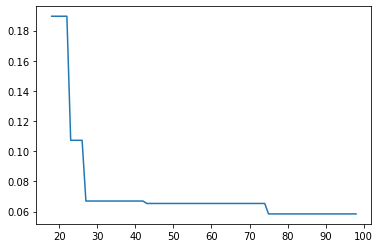

In [105]:
newdb = pd.DataFrame({"DriverAge": np.arange(18,99,1), "Exposure": np.ones_like(np.arange(18,99,1))})
newdb["DriverAge_binned"]  = pd.cut(newdb.DriverAge , bins=[17,22,26,42,74,np.inf])
result.predict(newdb,offset=np.log(newdb["Exposure"]))
plt.plot(newdb["DriverAge"], result.predict(newdb,offset=np.log(newdb["Exposure"])))


In [106]:
glm_preprocessor = ColumnTransformer(
    [
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["DriverAge_binned"],
        ),
    ],
    remainder="drop",
)
glm_preprocessor2 = ColumnTransformer(
    [
       ("passthrough_numeric", "passthrough", ["DriverAge"])
    ],
    remainder="drop",
)
glm_preprocessor.fit_transform(df)
glm_preprocessor2.fit_transform(df)

array([[46],
       [46],
       [38],
       ...,
       [49],
       [41],
       [29]], dtype=int64)

In [107]:
from sklearn.linear_model import PoissonRegressor
preg =PoissonRegressor(solver="newton-cholesky", max_iter = 10000,tol = 1e-10).fit(glm_preprocessor.transform(df),df.Frequency, sample_weight=df["Exposure"])
preg2 =PoissonRegressor(solver="newton-cholesky").fit(glm_preprocessor2.transform(df),df.Frequency, sample_weight=df["Exposure"])


In [79]:
sum(df[df.DriverAge>95].Frequency)

4.0

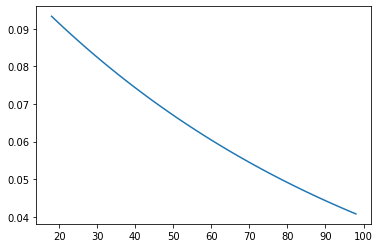

In [110]:
newdb = pd.DataFrame({"DriverAge": np.arange(18,99,1), "Exposure": np.ones_like(np.arange(18,99,1))})
newdb["DriverAge_binned"]  = pd.cut(newdb.DriverAge , bins=[17,22,26,42,74,np.inf])
plt.plot(newdb["DriverAge"], preg2.predict(glm_preprocessor2.transform(newdb)))

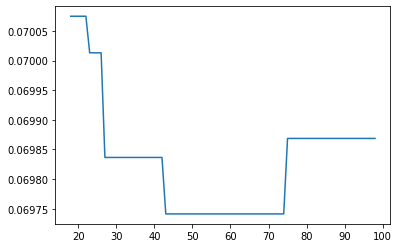

In [111]:
newdb = pd.DataFrame({"DriverAge": np.arange(18,99,1), "Exposure": np.ones_like(np.arange(18,99,1))})
newdb["DriverAge_binned"]  = pd.cut(newdb.DriverAge , bins=[17,22,26,42,74,np.inf])
plt.plot(newdb["DriverAge"], preg.predict(glm_preprocessor.transform(newdb))*newdb["Exposure"])

In [42]:
df.Brand.unique()

array(['Japanese (except Nissan) or Korean', 'Fiat',
       'Opel, General Motors or Ford', 'Mercedes, Chrysler or BMW',
       'Renault, Nissan or Citroen', 'Volkswagen, Audi, Skoda or Seat',
       'other'], dtype=object)

In [7]:
brand_to_letter = {'Japanese (except Nissan) or Korean': "F",
                   'Fiat':"D",
                    'Opel, General Motors or Ford':"C",
                      'Mercedes, Chrysler or BMW': "E",
                      'Renault, Nissan or Citroen': "A",
                     'Volkswagen, Audi, Skoda or Seat':"B",
                      'other':"G" }


In [8]:
df.Brand = df.Brand.apply(lambda x: brand_to_letter[x])

In [9]:
print(
    "Average Frequency = {}".format(np.average(df["Frequency"], weights=df["Exposure"]))
)
print(
    "Fraction of exposure with zero claims = {0:.1%}".format(
        df.loc[df["ClaimNb"] == 0, "Exposure"].sum() / df["Exposure"].sum()
    )
)

print(
    "Fraction of exposure with one claim = {0:.1%}".format(
        df.loc[df["ClaimNb"] == 1, "Exposure"].sum() / df["Exposure"].sum()
    )
)
print(
    "Fraction of exposure with more than one claim = {0:.1%}".format(
        df.loc[df["ClaimNb"] > 1, "Exposure"].sum() / df["Exposure"].sum()
    )
)
print(
    "Fraction of policyholders with exposure equal one = {0:.1%}".format(
        np.sum(df["Exposure"] == 1)/df.shape[0]
    )
)
print(
    "Fraction of policyholders with exposure below one = {0:.1%}".format(
        np.sum(df["Exposure"] < 1)/df.shape[0]
    )
)
print(
    "Fraction of policyholders with exposure above one = {0:.1%}".format(
        np.sum(df["Exposure"] > 1)/df.shape[0]
    )
)

Average Frequency = 0.06979858984933181
Fraction of exposure with zero claims = 95.3%
Fraction of exposure with one claim = 4.5%
Fraction of exposure with more than one claim = 0.2%
Fraction of policyholders with exposure equal one = 29.4%
Fraction of policyholders with exposure below one = 70.5%
Fraction of policyholders with exposure above one = 0.1%


In [54]:
plot_params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
         'figure.autolayout': True,
          "font.family" : "serif",
          'text.latex.preamble': r"\usepackage{amsmath}",
          "font.serif" : ["Computer Modern Serif"]
          }


plt.rcParams.update(plot_params)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(6.67*1.5*2/3, 4*1.5/2), dpi = 500)
ax0.set_title("Number of claims",fontsize=10)
ax0.set_ylabel("log frequency",fontsize=10)
ax0.set_xlabel(r"$\mathtt{ClaimNb}$",fontsize=10)
sns.histplot(df["ClaimNb"],ax=ax0,element="bars",
    stat="count",log_scale=(False, True),discrete = True)
#_ = df["ClaimNb"].hist(bins=30, log=True, ax=ax0)
ax1.set_title("Exposure in years",fontsize=10)
ax1.set_ylabel("log frequency",fontsize=10)
ax1.set_xlabel(r"$\mathtt{Exposure}$",fontsize=10)
sns.histplot(df["Exposure"],ax=ax1,element="bars",
    stat="count",log_scale=(False, True),bins=30)

# ax2.set_title("Frequency (number of claims per year)",fontsize=10)
# ax2.set_ylabel("log frequency",fontsize=10)
# ax2.set_xlabel("Claim Frequency",fontsize=10)
# #_ = df["Frequency"].hist(bins=30, log=True, ax=ax2)
# sns.histplot(df["Frequency"],ax=ax2,element="bars",
#     stat="count",log_scale=(False, True))

plt.tight_layout()
plt.savefig(f"..\\StableTrees_examples\plots\\freMTPLfreq_hist.png", transparent=False, dpi=500, facecolor='white',
            bbox_inches='tight')
plt.close()

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following

In [58]:
plot_params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
         'figure.autolayout': True,
          "font.family" : "serif",
          'text.latex.preamble': r"\usepackage{amsmath}",
          "font.serif" : ["Computer Modern Serif"]
          }


plt.rcParams.update(plot_params)
fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(6.67*1.5, 4*1.5), dpi = 500)
axs[0,0].set_ylabel("Relative frequency",fontsize=10)
axs[0,0].set_xlabel(r"$\mathtt{Power}$",fontsize=10)
sns.histplot(df["Power"].sort_values(),bins =30,ax=axs[0,0],element="bars",
    stat="probability")
axs[0,1].set_ylabel("Relative frequency",fontsize=10)
axs[0,1].set_xlabel(r"$\mathtt{CarAge}$",fontsize=10)
_ = sns.histplot(df["CarAge"],bins =50,ax=axs[0,1],element="bars",
    stat="probability")

axs[0,2].set_ylabel("Relative frequency",fontsize=10)
axs[0,2].set_xlabel(r"$\mathtt{DriverAge}$",fontsize=10)
_ = sns.histplot(df["DriverAge"],bins =25,ax=axs[0,2],element="bars",
    stat="probability")

axs[1,0].set_ylabel("Relative frequency",fontsize=10)
axs[1,0].set_xlabel(r"$\mathtt{Brand}$",fontsize=10)
_ = sns.histplot(df["Brand"].sort_values(),bins =30,ax=axs[1,0],element="bars",
    stat="probability")

axs[1,1].set_ylabel("Relative frequency",fontsize=10)
axs[1,1].set_xlabel(r"$\mathtt{Gas}$",fontsize=10)
_ = sns.histplot(df["Gas"],bins =30,ax=axs[1,1],element="bars",
    stat="probability")

axs[1,2].set_ylabel("Relative frequency",fontsize=10)
axs[1,2].set_xlabel(r"$\mathtt{Density}$",fontsize=10)
_ = sns.histplot((df["Density"]),bins =5,ax=axs[1,2],element="bars",
    stat="probability")


plt.tight_layout()
plt.savefig(f"..\\StableTrees_examples\plots\\claim_frequency_hist_features.png", transparent=False, dpi=500, facecolor='white',
            bbox_inches='tight')
plt.close()

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following

<Axes: xlabel='Density', ylabel='Probability'>

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following

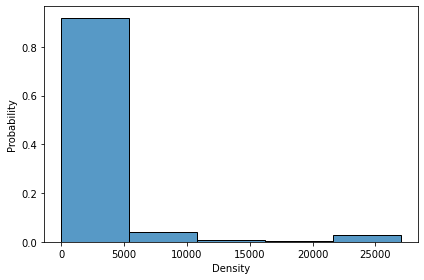

In [57]:
sns.histplot((df["Density"]),bins =5,element="bars",
    stat="probability")

In [8]:
df.Region.unique()

#  Aquitaine: FR-NAQ
#  Nord-Pas-de-Calais:	FR-62
# Pays-de-la-Loire : FR-PDL
# Ile-de-France :FR-IDF
# Centre :FR-CVL
# Poitou-Charentes : ?
# Bretagne : FR-BRE

array(['Aquitaine', 'Nord-Pas-de-Calais', 'Pays-de-la-Loire',
       'Ile-de-France', 'Centre', 'Poitou-Charentes', 'Bretagne',
       'Basse-Normandie', 'Limousin', 'Haute-Normandie'], dtype=object)

In [101]:
df.columns

Index(['PolicyID', 'ClaimNb', 'Exposure', 'Power', 'CarAge', 'DriverAge',
       'Brand', 'Gas', 'Region', 'Density', 'Density_binned',
       'DriverAge_binned', 'CarAge_binned', 'brandF', 'Power_glm',
       'Frequency'],
      dtype='object')

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following

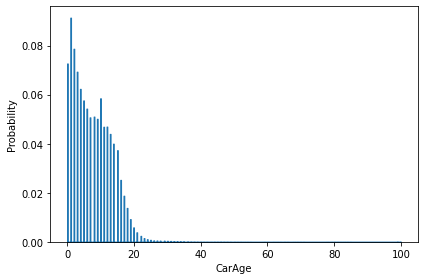

In [105]:
import seaborn as sns
sns.histplot(
    df.CarAge, element="step",
    stat="probability",
)
plt.show()

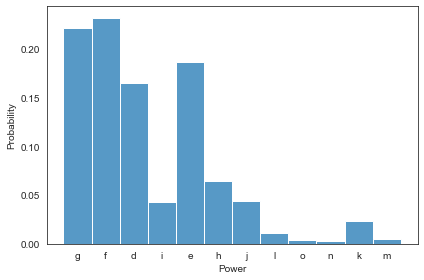

In [118]:
import seaborn as sns
sns.histplot(
    df.Power, element="bars",
    stat="probability"
)
plt.show()


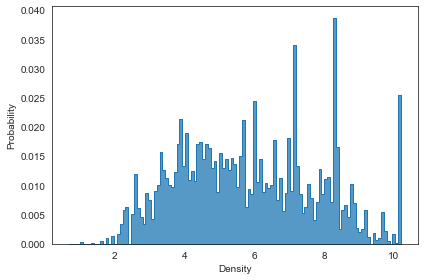

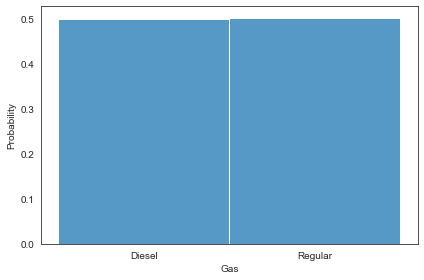

c:\Users\mb-92\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


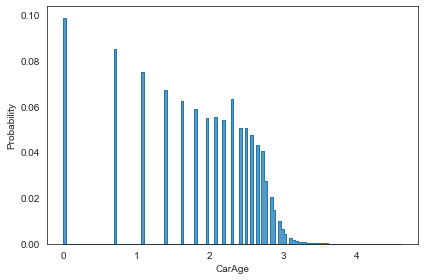

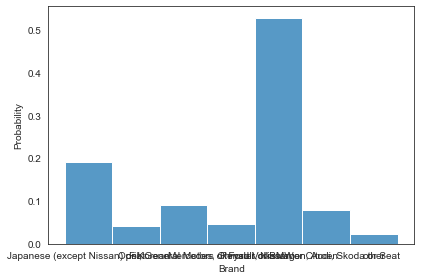

In [122]:
import seaborn as sns
sns.set_style("white")
sns.histplot(
    np.log(df.Density), element="step",
    stat="probability"
)
plt.show()
sns.histplot(
    df.Gas, element="bars",
    stat="probability"
)
plt.show()
sns.histplot(
    np.log(df.CarAge), element="step",
    stat="probability"
)
plt.show()
sns.histplot(
    df.Brand, element="bars",
    stat="probability"
)
plt.show()

## Density
The density of inhabitants (number of inhabitants per km2) in the city the driver of the car lives in.

In [10]:
df["Density_binned"] = pd.cut(df.Density, include_lowest=True, bins=[0,40,200,500,4500,np.inf])

## DrivAge
The driver age, in years (in France, people can drive a car at 18).

In [11]:
df["DriverAge_binned"]  = pd.cut(df.DriverAge , bins=[17,22,26,42,74,np.inf])

## VehAge 
The vehicle age, in years.

In [12]:
df["CarAge_binned"]  = pd.cut(df.CarAge, include_lowest=True , bins=[0,15,np.inf])

## Brand


In [13]:
df["brandF"] = np.where(df.Brand=="Japanese (except Nissan) or Korean","F","other")

## Power

In [14]:
df["Power_glm"] = ["DEF" if p in ["d","e","f"] else "other" if p in ["d","e","f"] else "GH" for p in df.Power ]

In [15]:
df.insert(len(df.columns)-1, 'Frequency', df.pop('Frequency'))

In [16]:
df

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,Density_binned,DriverAge_binned,CarAge_binned,brandF,Power_glm,Frequency
0,1,0,0.090000,g,0,46,F,Diesel,Aquitaine,76,"(40.0, 200.0]","(42.0, 74.0]","(-0.001, 15.0]",other,GH,0.0
1,2,0,0.840000,g,0,46,F,Diesel,Aquitaine,76,"(40.0, 200.0]","(42.0, 74.0]","(-0.001, 15.0]",other,GH,0.0
2,3,0,0.520000,f,2,38,F,Regular,Nord-Pas-de-Calais,3003,"(500.0, 4500.0]","(26.0, 42.0]","(-0.001, 15.0]",other,DEF,0.0
3,4,0,0.450000,f,2,38,F,Regular,Nord-Pas-de-Calais,3003,"(500.0, 4500.0]","(26.0, 42.0]","(-0.001, 15.0]",other,DEF,0.0
4,5,0,0.150000,g,0,41,F,Diesel,Pays-de-la-Loire,60,"(40.0, 200.0]","(26.0, 42.0]","(-0.001, 15.0]",other,GH,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413164,413165,0,0.002740,j,0,29,F,Diesel,Ile-de-France,2471,"(500.0, 4500.0]","(26.0, 42.0]","(-0.001, 15.0]",other,GH,0.0
413165,413166,0,0.005479,d,0,29,F,Regular,Ile-de-France,5360,"(4500.0, inf]","(26.0, 42.0]","(-0.001, 15.0]",other,DEF,0.0
413166,413167,0,0.005479,k,0,49,F,Diesel,Ile-de-France,5360,"(4500.0, inf]","(42.0, 74.0]","(-0.001, 15.0]",other,GH,0.0
413167,413168,0,0.002740,d,0,41,F,Regular,Ile-de-France,9850,"(4500.0, inf]","(26.0, 42.0]","(-0.001, 15.0]",other,DEF,0.0


In [17]:
# tree_preprocessor = ColumnTransformer(
#     [
#         (
#             "categorical",
#             OrdinalEncoder(),
#             ["CarAge", "DriverAge", "Gas", "Density"],
#         ),
#         (
#             "onehot_categorical",
#             OneHotEncoder(),
#             ["Power", "brandF"],
#         ),
#         ("numeric", "passthrough", ["y"]),
#     ],
#     remainder="drop",
# )

tree_preprocessor = ColumnTransformer(
    [
        ("categorical",
            OrdinalEncoder(),
            ["Brand", "Power", "Gas", "Region"],
        ),
        ("numeric", "passthrough", ["CarAge","DriverAge","Density"]),
    ],
    remainder="drop",
)

# glm_preprocessor = ColumnTransformer(
#     [
#         (
#             "categorical",
#             OrdinalEncoder(),
#             ["CarAge_binned", "DriverAge_binned", "Density"],
#         ),
#         (
#             "onehot_categorical",
#             OneHotEncoder(),
#             ["Gas","Power_glm", "brandF"],
#         ),
#     ],
#     remainder="drop",
# )
glm_preprocessor = ColumnTransformer(
    [
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["CarAge_binned","Gas","Power_glm", "brandF","DriverAge_binned", "Density_binned"],
        ),
    ],
    remainder="drop",
)

In [18]:
tree_preprocessor.fit_transform(df)
glm_preprocessor.fit_transform(df)
df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)
tree_preprocessor.transform(df_train)

array([[0.0000e+00, 2.0000e+00, 0.0000e+00, ..., 4.0000e+00, 5.5000e+01,
        1.6300e+02],
       [5.0000e+00, 1.0000e+00, 1.0000e+00, ..., 4.0000e+00, 3.3000e+01,
        3.0230e+03],
       [3.0000e+00, 1.0000e+00, 0.0000e+00, ..., 3.0000e+00, 2.7000e+01,
        4.3480e+03],
       ...,
       [2.0000e+00, 3.0000e+00, 0.0000e+00, ..., 7.0000e+00, 2.7000e+01,
        9.1000e+01],
       [0.0000e+00, 3.0000e+00, 0.0000e+00, ..., 5.0000e+00, 2.7000e+01,
        1.0900e+02],
       [5.0000e+00, 3.0000e+00, 1.0000e+00, ..., 0.0000e+00, 3.3000e+01,
        1.0477e+04]])

In [18]:
from sklearn.ensemble import HistGradientBoostingRegressor
poisson_gbrt = HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=128)

poisson_gbrt.fit(
    tree_preprocessor.transform(df_train),df_train.Frequency, sample_weight=df_train["Exposure"])
pred = poisson_gbrt.predict(tree_preprocessor.transform(df_test) )
mask = pred > 0
mean_poisson_deviance(df_test.Frequency[mask], pred[mask], sample_weight = df_test["Exposure"][mask])

0.4559567770902345

In [20]:
from sklearn.ensemble import RandomForestRegressor
poisson_rf = RandomForestRegressor(criterion="poisson",n_jobs=-1, max_features = 1/3,n_estimators = 100,random_state=0)

poisson_rf.fit(
    tree_preprocessor.transform(df_train),df_train.Frequency, sample_weight=df_train["Exposure"])
pred = poisson_rf.predict(tree_preprocessor.transform(df_test) )

mean_poisson_deviance(df_test.Frequency, pred, sample_weight = df_test["Exposure"])

0.47059952017750983

In [23]:
tree_preprocessor.fit_transform(df)
df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

t = BaseLineTree(criterion="poisson",adaptive_complexity=True).fit(tree_preprocessor.transform(df_train),df_train.Frequency,sample_weight=df_train["Exposure"])
pred = t.predict(tree_preprocessor.transform(df_test) )

mean_poisson_deviance(df_test.Frequency, pred, sample_weight = df_test["Exposure"])


0.4553406619414742

In [22]:
from stabletrees.random_forest import RF
tree_preprocessor.fit_transform(df)
df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

t = RF("base",criterion="poisson",adaptive_complexity=True,max_features="third").fit(tree_preprocessor.transform(df_train),df_train.Frequency,sample_weight=df_train["Exposure"])
pred = t.predict(tree_preprocessor.transform(df_test) )

mean_poisson_deviance(df_test.Frequency, pred, sample_weight = df_test["Exposure"])


0.4540457865902426

In [25]:
from stabletrees.random_forest import RF
tree_preprocessor.fit_transform(df)
df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

t = RF("base",criterion="poisson",adaptive_complexity=True,max_features="all").fit(tree_preprocessor.transform(df_train),df_train.Frequency,sample_weight=df_train["Exposure"])
pred = t.predict(tree_preprocessor.transform(df_test) )

mean_poisson_deviance(df_test.Frequency, pred, sample_weight = df_test["Exposure"])


0.4540418072504001

In [24]:
from sklearn.tree import DecisionTreeRegressor
poisson_t = DecisionTreeRegressor(criterion="poisson", ccp_alpha = 0.0001, min_samples_leaf =5)

poisson_t.fit(
    tree_preprocessor.transform(df_train),df_train.Frequency, sample_weight=df_train["Exposure"])
pred = poisson_t.predict(tree_preprocessor.transform(df_test) )
mask = pred > 0
mean_poisson_deviance(df_test.Frequency, pred, sample_weight = df_test["Exposure"])

0.45633302474185095

In [23]:
from sklearn.dummy import DummyRegressor
dr = DummyRegressor(strategy="mean").fit(tree_preprocessor.transform(df_train),df_train.Frequency , sample_weight=df_train["Exposure"])
pred = dr.predict(tree_preprocessor.transform(df_test) )
mask = pred > 0
mean_poisson_deviance(df_test.Frequency[mask], pred[mask], sample_weight = df_test["Exposure"][mask])

0.4632362029844828

In [54]:
from sklearn.linear_model import PoissonRegressor
glm_preprocessor.fit_transform(df)
poisson_glm = PoissonRegressor(solver="newton-cholesky")

poisson_glm.fit(
    glm_preprocessor.transform(df_train), df_train["Frequency"], sample_weight=df_train["Exposure"]
)
pred = poisson_glm.predict(glm_preprocessor.transform(df_test) )
mask = pred > 0
mean_poisson_deviance(df_test.Frequency[mask], pred[mask], sample_weight = df_test["Exposure"][mask])
poisson_glm.coef_

array([-1.34195924e-03, -8.76375298e-03, -2.98394289e-03,  4.15752258e-04,
        2.98394289e-03, -2.98394289e-03,  6.83751167e-05, -6.83751167e-05,
       -1.49503407e-03,  1.49503407e-03])

In [57]:
glm_preprocessor.fit_transform(df)
import statsmodels.api as sm
X = sm.add_constant(glm_preprocessor.transform(df_train))  # Add a constant term for the intercept
poisson_model = sm.GLM(df_train.ClaimNb, X, family=sm.families.Poisson(),offset=df_train["Exposure"])
poisson_results = poisson_model.fit()
poisson_results.pvalues

const    0.000000e+00
x1       2.559803e-11
x2       7.161027e-35
x3       0.000000e+00
x4       2.784222e-49
x5       0.000000e+00
x6       0.000000e+00
x7       0.000000e+00
x8       0.000000e+00
x9       0.000000e+00
x10      0.000000e+00
dtype: float64

In [53]:
from sklearn.linear_model import PoissonRegressor
glm_preprocessor2.fit_transform(df)
poisson_glm = PoissonRegressor(solver="newton-cholesky")

poisson_glm.fit(
    glm_preprocessor2.transform(df_train), df_train["Frequency"], sample_weight=df_train["Exposure"]
)
pred = poisson_glm.predict(glm_preprocessor2.transform(df_test) )
mask = pred > 0
mean_poisson_deviance(df_test.Frequency[mask], pred[mask], sample_weight = df_test["Exposure"][mask])
poisson_glm.coef_

array([ 1.57299677e-03, -1.57299677e-03,  2.13018298e-03, ...,
        1.80898914e-07,  1.60519926e-05,  5.27990813e-04])

In [34]:
df_prep = tree_preprocessor.fit_transform(df)
X = df_prep[:,:-1]
y = df_prep[:,-1]
y = y

In [35]:
t = BaseLineTree(criterion="poisson",adaptive_complexity=True).fit(X,y)
mask = ClaimNb!=0
mean_poisson_deviance(ClaimNb,t.predict(X)*Exposure)


0.26500686903527537

In [36]:
from sklearn.linear_model import PoissonRegressor
lm = PoissonRegressor(alpha=0.001).fit(X,y,sample_weight=Exposure)
mask = ClaimNb!=0
mean_poisson_deviance(ClaimNb,lm.predict(X)*Exposure)



c:\Users\mb-92\anaconda3\lib\site-packages\sklearn\linear_model\_linear_loss.py:289: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights


0.25561609212166087

In [25]:
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedKFold
EPSILON = 1.1

def S1(pred1, pred2):
    return np.std(np.log((pred2+EPSILON)/(pred1+EPSILON)))

def S2(pred1, pred2):
    return np.mean((pred1- pred2)**2)

In [30]:
from sklearn.linear_model import PoissonRegressor
criterion = "poisson"
parameters = {"ccp_alpha" : [1e-4]}
models = {  
            "baseline": BaseLineTree(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "sklearn": GridSearchCV(DecisionTreeRegressor(criterion="poisson",random_state=0), parameters),
            "poisReg": PoissonRegressor(solver="newton-cholesky"),
            "TR": TreeReevaluation(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "SL": StabilityRegularization(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "ABU": AbuTree(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "BABU": BABUTree(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "GGTB" : HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=128)
            }
stability_all = {name:[] for name in models.keys()}
standard_stability_all= {name:[] for name in models.keys()}
mse_all= {name:[] for name in models.keys()}

stability = {name:[] for name in models.keys()}
standard_stability = {name:[] for name in models.keys()}
mse = {name:[] for name in models.keys()}
train_stability = {name:[] for name in models.keys()}
train_standard_stability = {name:[] for name in models.keys()}
train_mse = {name:[] for name in models.keys()}
orig_stability = {name:[] for name in models.keys()}
orig_standard_stability = {name:[] for name in models.keys()}
orig_mse = {name:[] for name in models.keys()}
#parameters = {"ccp_alpha" : [0,0.01,1e-3,1e-4, 1e-5]}
parameters = {"ccp_alpha" : [1e-4]}

#clf = GridSearchCV(DecisionTreeRegressor(random_state=0, criterion="poisson"), parameters)
kf = RepeatedKFold(n_splits= 6,n_repeats=1, random_state=SEED)
for train_index, test_index in kf.split(df.to_numpy()):
    df_12 = df.iloc[train_index]

    df_test = df.iloc[test_index]

    df_1,df_2 =  train_test_split(df_12, test_size=0.5, random_state=SEED)
    # clf.fit(X1,y1)
    # params = clf.best_params_
    # initial model 
    criterion = "poisson"
    models = {  
            "baseline": BaseLineTree(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "sklearn": GridSearchCV(DecisionTreeRegressor(criterion="poisson",random_state=0), parameters),
            "poisReg": PoissonRegressor(solver="newton-cholesky"),
            "TR": TreeReevaluation(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "SL": StabilityRegularization(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "ABU": AbuTree(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "BABU": BABUTree(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "GGTB" : HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=128)
            }
    
    for name, model in models.items():
        if name == "poisReg":
            preprocessor = glm_preprocessor            
        else:
            preprocessor = tree_preprocessor

        model.fit(preprocessor.transform(df_1),df_1.Frequency, sample_weight=df_1["Exposure"])
            
        
        pred1 = model.predict(preprocessor.transform(df_test) )

        #print("before")
        if name == "poisReg":
            model.fit(preprocessor.transform(df_train),df_train.Frequency, sample_weight=df_train["Exposure"])
        elif name == "sklearn":
            model.fit(preprocessor.transform(df_train),df_train.Frequency, sample_weight=df_train["Exposure"])
            params = model.best_params_
            #print(params)
        elif name == "GGTB":
            model.fit(preprocessor.transform(df_train),df_train.Frequency, sample_weight=df_train["Exposure"])
            #print(params)
        else:
            model.update(preprocessor.transform(df_train),df_train.Frequency, sample_weight=df_train["Exposure"])

        #print("after")
        pred2 = model.predict(preprocessor.transform(df_test) )

        mse[name].append(mean_poisson_deviance(df_test.Frequency, pred2, sample_weight = df_test["Exposure"]))
        stability[name].append(S1(pred1,pred2))

    
for name in models.keys():
    print("="*80)
    print(f"{name}")
    mse_scale = np.mean(mse["baseline"]); S1_scale = np.mean(stability["baseline"]); S2_scale = np.mean(standard_stability["baseline"]);
    
    print(f"test - poisson: {np.mean(mse[name]):.3f} ({np.mean(mse[name])/mse_scale:.3f}), stability: {np.mean(stability[name]):.4f} ({np.mean(stability[name])/S1_scale:.3f})")
    print("="*80)

print()

baseline
test - poisson: 0.448 (1.000), stability: 0.0195 (1.000)
sklearn
test - poisson: 0.449 (1.003), stability: 0.0121 (0.620)
poisReg
test - poisson: 0.453 (1.012), stability: 0.0009 (0.049)
TR
test - poisson: 0.448 (1.000), stability: 0.0191 (0.981)
SL
test - poisson: 0.449 (1.003), stability: 0.0143 (0.735)
ABU
test - poisson: 0.448 (1.000), stability: 0.0193 (0.994)
BABU
test - poisson: 0.448 (1.001), stability: 0.0177 (0.911)
GGTB
test - poisson: 0.433 (0.967), stability: 0.0284 (1.461)



c:\Users\mb-92\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mb-92\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [31]:
from sklearn.linear_model import PoissonRegressor
criterion = "poisson"
parameters = {"ccp_alpha" : [1e-4]}
models = {  
            "baseline": BaseLineTree(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "sklearn": GridSearchCV(DecisionTreeRegressor(criterion="poisson",random_state=0), parameters),
            "poisReg": PoissonRegressor(solver="newton-cholesky"),
            "TR": TreeReevaluation(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "SL": StabilityRegularization(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "ABU": AbuTree(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "BABU": BABUTree(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "GGTB" : HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=128)
            }
stability_all = {name:[] for name in models.keys()}
standard_stability_all= {name:[] for name in models.keys()}
mse_all= {name:[] for name in models.keys()}

stability = {name:[] for name in models.keys()}
standard_stability = {name:[] for name in models.keys()}
mse = {name:[] for name in models.keys()}
train_stability = {name:[] for name in models.keys()}
train_standard_stability = {name:[] for name in models.keys()}
train_mse = {name:[] for name in models.keys()}
orig_stability = {name:[] for name in models.keys()}
orig_standard_stability = {name:[] for name in models.keys()}
orig_mse = {name:[] for name in models.keys()}
#parameters = {"ccp_alpha" : [0,0.01,1e-3,1e-4, 1e-5]}
parameters = {"ccp_alpha" : [1e-4]}

#clf = GridSearchCV(DecisionTreeRegressor(random_state=0, criterion="poisson"), parameters)
kf = RepeatedKFold(n_splits= 6,n_repeats=1, random_state=SEED)
for train_index, test_index in kf.split(df.to_numpy()):
    df_12 = df.iloc[train_index]

    df_test = df.iloc[test_index]

    df_1,df_2 =  train_test_split(df_12, test_size=0.5, random_state=SEED)
    # clf.fit(X1,y1)
    # params = clf.best_params_
    # initial model 
    criterion = "poisson"
    models = {  
            "baseline": BaseLineTree(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "sklearn": GridSearchCV(DecisionTreeRegressor(criterion="poisson",random_state=0), parameters),
            "poisReg": PoissonRegressor(solver="newton-cholesky"),
            "TR": TreeReevaluation(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "SL": StabilityRegularization(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "ABU": AbuTree(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "BABU": BABUTree(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "GGTB" : HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=128)
            }
    
    for name, model in models.items():
        if name == "poisReg":
            preprocessor = glm_preprocessor            
        else:
            preprocessor = tree_preprocessor

        model.fit(preprocessor.transform(df_1),df_1.Frequency, sample_weight=df_1["Exposure"])
            
        
        pred1 = model.predict(preprocessor.transform(df_test) )

        #print("before")
        if name == "poisReg":
            model.fit(preprocessor.transform(df_12),df_12.Frequency, sample_weight=df_12["Exposure"])
        elif name == "sklearn":
            model.fit(preprocessor.transform(df_12),df_12.Frequency, sample_weight=df_12["Exposure"])
            params = model.best_params_
            #print(params)
        elif name == "GGTB":
            model.fit(preprocessor.transform(df_12),df_12.Frequency, sample_weight=df_12["Exposure"])
            #print(params)
        else:
            model.update(preprocessor.transform(df_12),df_12.Frequency, sample_weight=df_12["Exposure"])

        #print("after")
        pred2 = model.predict(preprocessor.transform(df_test) )

        mse[name].append(mean_poisson_deviance(df_test.ClaimNb, pred2*df_test.Exposure))
        stability[name].append(S1(pred1,pred2))

    
for name in models.keys():
    print("="*80)
    print(f"{name}")
    mse_scale = np.mean(mse["baseline"]); S1_scale = np.mean(stability["baseline"]); S2_scale = np.mean(standard_stability["baseline"]);
    
    print(f"test - poisson: {np.mean(mse[name]):.4f} ({np.mean(mse[name])/mse_scale:.3f}), stability: {np.mean(stability[name]):.4f} ({np.mean(stability[name])/S1_scale:.3f})")
    print("="*80)

print()

baseline
test - poisson: 0.252 (1.000), stability: 0.0184 (1.000)
sklearn
test - poisson: 0.252 (1.001), stability: 0.0112 (0.610)
poisReg
test - poisson: 0.254 (1.008), stability: 0.0004 (0.023)
TR
test - poisson: 0.252 (1.000), stability: 0.0178 (0.969)
SL
test - poisson: 0.252 (1.001), stability: 0.0139 (0.755)
ABU
test - poisson: 0.252 (1.000), stability: 0.0182 (0.991)
BABU
test - poisson: 0.252 (1.000), stability: 0.0169 (0.919)
GGTB
test - poisson: 0.252 (0.999), stability: 0.0273 (1.483)



c:\Users\mb-92\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mb-92\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [38]:
models = {  
            "baseline": BaseLineTree(),
            "sklearn": DecisionTreeRegressor(),
            "poisReg": PoissonRegressor(alpha=0.001),
            "NU": NaiveUpdate(),
            "TR":TreeReevaluation(delta=0.1),
            "SR":StabilityRegularization(),
            "ABU":AbuTreeI(),
            "BABU": BABUTree()
            }
stability_all = {name:[] for name in models.keys()}
standard_stability_all= {name:[] for name in models.keys()}
mse_all= {name:[] for name in models.keys()}

stability = {name:[] for name in models.keys()}
standard_stability = {name:[] for name in models.keys()}
mse = {name:[] for name in models.keys()}
train_stability = {name:[] for name in models.keys()}
train_standard_stability = {name:[] for name in models.keys()}
train_mse = {name:[] for name in models.keys()}
orig_stability = {name:[] for name in models.keys()}
orig_standard_stability = {name:[] for name in models.keys()}
orig_mse = {name:[] for name in models.keys()}
parameters = {'max_depth':[None, 5, 10],"min_samples_leaf": [5]} # , 
#clf = GridSearchCV(DecisionTreeRegressor(random_state=0, criterion="poisson"), parameters)
kf = RepeatedKFold(n_splits= 5,n_repeats=10, random_state=SEED)
for train_index, test_index in kf.split(X):
    X_12, y_12 = X[train_index],y[train_index]
    ClaimNb_12 = ClaimNb[train_index]
    Exposure_12  = Exposure[train_index]
    X_test,y_test = X[test_index],y[test_index]
    ClaimNb_test = ClaimNb[test_index]
    Exposure_test  = Exposure[test_index]
    X1,X2,y1,y2,ClaimNb_1,ClaimNb_2,Exposure_1,Exposure_2 =  train_test_split(X_12, y_12,ClaimNb_12,Exposure_12, test_size=0.5, random_state=SEED)
    # clf.fit(X1,y1)
    # params = clf.best_params_
    # initial model 
    criterion = "poisson"
    models = {  
            "baseline": BaseLineTree(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "sklearn": DecisionTreeRegressor(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "poisReg": PoissonRegressor(alpha=0.001),
            "NU": NaiveUpdate(criterion = criterion, adaptive_complexity=True),
            "TR":TreeReevaluation(criterion = criterion, adaptive_complexity=True, delta=0.1),
            "SR":StabilityRegularization(criterion = criterion, adaptive_complexity=True,lmbda=0.75),
            "ABU":AbuTreeI(criterion = criterion, adaptive_complexity=True),
            "BABU": BABUTree(criterion = criterion, adaptive_complexity=True),

            }
    for name, model in models.items():
        model.fit(X1,y1)
        
        pred1 = model.predict(X_test) 
        pred1_train = model.predict(X_12)
        pred1_orig= model.predict(X1)
        #print("before")
        if name == "poisReg":
            model.fit(X_12,y_12)
        elif name == "sklearn":
            model.fit(X_12,y_12)
        else:
            model.update(X_12,y_12)
        #print("after")
        pred2 = model.predict(X_test) 
        pred2_orig= model.predict(X1) 
        pred2_train =  model.predict(X_12)
        orig_mse[name].append(mean_poisson_deviance(ClaimNb_1+0.00001,pred2_orig*Exposure_1+0.00001))
        orig_stability[name].append(S1(pred1_orig*Exposure_1,pred2_orig*Exposure_1))
        orig_standard_stability[name].append(S2(pred1_orig*Exposure_1,pred2_orig*Exposure_1))

        train_mse[name].append(mean_poisson_deviance(ClaimNb_12+0.00001,pred2_train*Exposure_12+0.00001))
        train_stability[name].append(S1(pred1_train*Exposure_12,pred2_train*Exposure_12))
        train_standard_stability[name].append(S2(pred1_train*Exposure_12,pred2_train*Exposure_12))
        mse[name].append(mean_poisson_deviance(ClaimNb_test+0.00001,pred2*Exposure_test+0.00001))
        stability[name].append(S1(pred1*Exposure_test,pred2*Exposure_test))
        standard_stability[name].append(S2(pred1*Exposure_test,pred2*Exposure_test))
    
for name in models.keys():
    print("="*80)
    print(f"{name}")
    orig_mse_scale = np.mean(orig_mse["baseline"]); orig_S1_scale = np.mean(orig_stability["baseline"]); orig_S2_scale = np.mean(orig_standard_stability["baseline"]);
    train_mse_scale = np.mean(train_mse["baseline"]); train_S1_scale = np.mean(train_stability["baseline"]); train_S2_scale = np.mean(train_standard_stability["baseline"]);
    mse_scale = np.mean(mse["baseline"]); S1_scale = np.mean(stability["baseline"]); S2_scale = np.mean(standard_stability["baseline"]);
    
    print(f"orig - poisson: {np.mean(orig_mse[name]):.3f} ({np.mean(orig_mse[name])/orig_mse_scale:.2f}), stability: {np.mean(orig_stability[name]):.3f} ({np.mean(orig_stability[name])/orig_S1_scale:.2f}), standard stability: {np.mean(orig_standard_stability[name]):.3f} ({np.mean(orig_standard_stability[name])/orig_S2_scale:.2f})")
    print(f"train - poisson: {np.mean(train_mse[name]):.3f} ({np.mean(train_mse[name])/train_mse_scale:.2f}), stability: {np.mean(train_stability[name]):.3f} ({np.mean(train_stability[name])/train_S1_scale:.2f}), standard stability: {np.mean(train_standard_stability[name]):.3f} ({np.mean(train_standard_stability[name])/train_S2_scale:.2f})")
    print(f"test - poisson: {np.mean(mse[name]):.3f} ({np.mean(mse[name])/mse_scale:.2f}), stability: {np.mean(stability[name]):.3f} ({np.mean(stability[name])/S1_scale:.2f}), standard stability: {np.mean(standard_stability[name]):.3f} ({np.mean(standard_stability[name])/S2_scale:.2f})")
    print("="*80)
    mse_all[name] += [score/mse_scale for score in mse[name]]
    stability_all[name] += [score/S1_scale for score in stability[name]]
    standard_stability_all[name] += [score/S2_scale for score in standard_stability[name]]
print()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\Users\mb-92\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\mb-92\AppData\Local\Temp/ipykernel_40512/1212418532.py", line 8, in <module>
    "ABU":AbuTreeI(),
NameError: name 'AbuTreeI' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\mb-92\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2064, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\mb-92\anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "c:\Users\mb-92\anacond

TypeError: object of type 'NoneType' has no len()

In [ ]:
with tarfile.open("..\data\poisson\\norauto.tar.gz", "r:*") as tar:
    csv_path = tar.getnames()[0]
    df = pd.read_csv(tar.extractfile(csv_path), header=0)

In [ ]:
df.head()

,Male,Young,DistLimit,GeoRegion,Expo,ClaimAmount,NbClaim
0,0,0,12000 km,Low+,0.789,0.0,0
1,0,1,12000 km,Medium+,0.200,0.0,0
2,0,1,25000-30000 km,Medium+,0.285,0.0,0
3,0,0,12000 km,Medium-,0.247,0.0,0
4,0,0,12000 km,High-,0.995,18158.0,1


## distLimit
The distance limit as stated in the insurance contract: "8000 km", "12000 km", "16000 km", "20000 km", "25000-30000 km", "no limit".

In [ ]:
df["DistLimit_ints"] = pd.Categorical(df.DistLimit, categories=["8000 km", "12000 km", "16000 km", "20000 km","25000-30000 km", "no limit"], ordered=True).rename_categories(np.arange(6))

## GeoRegion
GeoRegion Density of the geographical region (from heaviest to lightest): "High+", "High-", "Medium+", "Medium-", "Low+", "Low-".

In [ ]:
np.unique(df.GeoRegion)

array(['High+', 'High-', 'Low+', 'Low-', 'Medium+', 'Medium-'],
      dtype=object)

In [ ]:
df["GeoRegion_ints"] = pd.Categorical(df.GeoRegion, categories=['Low-','Low+','Medium-', 'Medium+', 'High-','High+'], ordered=True).rename_categories(np.arange(6))

In [ ]:
df

,Male,Young,DistLimit,GeoRegion,Expo,ClaimAmount,NbClaim,DistLimit_ints,GeoRegion_ints
0,0,0,12000 km,Low+,0.789,0.0,0,1,1
1,0,1,12000 km,Medium+,0.200,0.0,0,1,3
2,0,1,25000-30000 km,Medium+,0.285,0.0,0,4,3
3,0,0,12000 km,Medium-,0.247,0.0,0,1,2
4,0,0,12000 km,High-,0.995,18158.0,1,1,4
...,...,...,...,...,...,...,...,...,...
183994,1,0,no limit,High-,0.430,0.0,0,5,4
183995,1,0,no limit,High+,0.718,27807.0,1,5,5
183996,1,0,25000-30000 km,High-,0.362,0.0,0,4,4
183997,1,0,25000-30000 km,High-,0.764,0.0,0,4,4


In [ ]:
df["y"] = df.NbClaim/df.Expo

In [ ]:
df.insert(len(df.columns)-1, 'y', df.pop('y'))

In [ ]:
ClaimNb = df.NbClaim.to_numpy()
Exposure = df.Expo.to_numpy()
df.drop(["DistLimit","GeoRegion","ClaimAmount","Expo","NbClaim"],axis=1,inplace=True)

In [ ]:
df

,Male,Young,DistLimit,GeoRegion,Expo,ClaimAmount,NbClaim,DistLimit_ints,GeoRegion_ints,y
0,0,0,12000 km,Low+,0.789,0.0,0,1,1,0.000000
1,0,1,12000 km,Medium+,0.200,0.0,0,1,3,0.000000
2,0,1,25000-30000 km,Medium+,0.285,0.0,0,4,3,0.000000
3,0,0,12000 km,Medium-,0.247,0.0,0,1,2,0.000000
4,0,0,12000 km,High-,0.995,18158.0,1,1,4,1.005025
...,...,...,...,...,...,...,...,...,...,...
183994,1,0,no limit,High-,0.430,0.0,0,5,4,0.000000
183995,1,0,no limit,High+,0.718,27807.0,1,5,5,1.392758
183996,1,0,25000-30000 km,High-,0.362,0.0,0,4,4,0.000000
183997,1,0,25000-30000 km,High-,0.764,0.0,0,4,4,0.000000


In [ ]:
X = df.to_numpy()[:,:-1]
y = df.to_numpy()[:,-1]

In [ ]:
lm = PoissonRegressor(alpha=0.001).fit(X,y,sample_weight= Exposure)
mean_poisson_deviance(ClaimNb,lm.predict(X)*Exposure)

0.27005900609236994

In [ ]:
t = BaseLineTree(criterion="poisson",adaptive_complexity=True).fit(X,y)
mean_poisson_deviance(ClaimNb,t.predict(X)*Exposure)


0.2702241057900478

In [ ]:
t = StabilityRegularization(criterion = "poisson", adaptive_complexity=True,gamma=0.75).fit(X,y)
t.update(X,y)
mean_poisson_deviance(ClaimNb,t.predict(X)*Exposure)

0.27013356020907114

In [ ]:
models = {  
            "baseline": BaseLineTree(),
            "poisReg": PoissonRegressor(alpha=0.001),
            "NU": NaiveUpdate(),
            "TR":TreeReevaluation(delta=0.1),
            "SR":StabilityRegularization(),
            "ABU":AbuTree(),
            "BABU": BABUTree()
            }
stability_all = {name:[] for name in models.keys()}
standard_stability_all= {name:[] for name in models.keys()}
mse_all= {name:[] for name in models.keys()}

stability = {name:[] for name in models.keys()}
standard_stability = {name:[] for name in models.keys()}
mse = {name:[] for name in models.keys()}
train_stability = {name:[] for name in models.keys()}
train_standard_stability = {name:[] for name in models.keys()}
train_mse = {name:[] for name in models.keys()}
orig_stability = {name:[] for name in models.keys()}
orig_standard_stability = {name:[] for name in models.keys()}
orig_mse = {name:[] for name in models.keys()}
kf = RepeatedKFold(n_splits= 5,n_repeats=10, random_state=SEED)
for train_index, test_index in kf.split(X):
    X_12, y_12 = X[train_index],y[train_index]
    ClaimNb_12 = ClaimNb[train_index]
    Exposure_12  = Exposure[train_index]
    X_test,y_test = X[test_index],y[test_index]
    ClaimNb_test = ClaimNb[test_index]
    Exposure_test  = Exposure[test_index]
    X1,X2,y1,y2,ClaimNb_1,ClaimNb_2,Exposure_1,Exposure_2 =  train_test_split(X_12, y_12,ClaimNb_12,Exposure_12, test_size=0.5, random_state=SEED)
   
    # initial model 
    criterion = "poisson"
    models = {  
            "baseline": BaseLineTree(criterion = criterion, adaptive_complexity=True),
            "poisReg": PoissonRegressor(alpha=0.001),
            "NU": NaiveUpdate(criterion = criterion, adaptive_complexity=True),
            "TR":TreeReevaluation(criterion = criterion, adaptive_complexity=True, delta=0.1),
            "SR":StabilityRegularization(criterion = criterion, adaptive_complexity=True,gamma=0.75),
            "ABU":AbuTree(criterion = criterion, adaptive_complexity=True),
            "BABU": BABUTree(criterion = criterion, adaptive_complexity=True),

            }
    for name, model in models.items():
        if name == "poisReg":
            model.fit(X1,y1,sample_weight= Exposure_1)
        else:
            model.fit(X1,y1)
        
        pred1 = model.predict(X_test)
        pred1_train = model.predict(X_12)
        pred1_orig= model.predict(X1)
        #print("before")
        
            
        if name == "poisReg":
            model.fit(X_12,y_12,sample_weight= Exposure_12)
        else:
            model.update(X_12,y_12)
        #print("after")
        pred2 = model.predict(X_test)
        pred2_orig= model.predict(X1)
        pred2_train =  model.predict(X_12)
        orig_mse[name].append(mean_poisson_deviance(ClaimNb_1+0.00001,pred2_orig*Exposure_1+0.00001))
        orig_stability[name].append(S1(pred1_orig*Exposure_1,pred2_orig*Exposure_1))
        orig_standard_stability[name].append(S2(pred1_orig*Exposure_1,pred2_orig*Exposure_1))

        train_mse[name].append(mean_poisson_deviance(ClaimNb_12+0.00001,pred2_train*Exposure_12+0.00001))
        train_stability[name].append(S1(pred1_train*Exposure_12,pred2_train*Exposure_12))
        train_standard_stability[name].append(S2(pred1_train*Exposure_12,pred2_train*Exposure_12))
        mse[name].append(mean_poisson_deviance(ClaimNb_test+0.00001,pred2*Exposure_test+0.00001))
        stability[name].append(S1(pred1*Exposure_test,pred2*Exposure_test))
        standard_stability[name].append(S2(pred1*Exposure_test,pred2*Exposure_test))
    
for name in models.keys():
    print("="*80)
    print(f"{name}")
    orig_mse_scale = np.mean(orig_mse["baseline"]); orig_S1_scale = np.mean(orig_stability["baseline"]); orig_S2_scale = np.mean(orig_standard_stability["baseline"]);
    train_mse_scale = np.mean(train_mse["baseline"]); train_S1_scale = np.mean(train_stability["baseline"]); train_S2_scale = np.mean(train_standard_stability["baseline"]);
    mse_scale = np.mean(mse["baseline"]); S1_scale = np.mean(stability["baseline"]); S2_scale = np.mean(standard_stability["baseline"]);
    
    print(f"orig - poisson: {np.mean(orig_mse[name]):.3f} ({np.mean(orig_mse[name])/orig_mse_scale:.2f}), stability: {np.mean(orig_stability[name]):.3f} ({np.mean(orig_stability[name])/orig_S1_scale:.2f}), standard stability: {np.mean(orig_standard_stability[name]):.3f} ({np.mean(orig_standard_stability[name])/orig_S2_scale:.2f})")
    print(f"train - poisson: {np.mean(train_mse[name]):.3f} ({np.mean(train_mse[name])/train_mse_scale:.2f}), stability: {np.mean(train_stability[name]):.3f} ({np.mean(train_stability[name])/train_S1_scale:.2f}), standard stability: {np.mean(train_standard_stability[name]):.3f} ({np.mean(train_standard_stability[name])/train_S2_scale:.2f})")
    print(f"test - poisson: {np.mean(mse[name]):.3f} ({np.mean(mse[name])/mse_scale:.2f}), stability: {np.mean(stability[name]):.3f} ({np.mean(stability[name])/S1_scale:.2f}), standard stability: {np.mean(standard_stability[name]):.3f} ({np.mean(standard_stability[name])/S2_scale:.2f})")
    print("="*80)
    mse_all[name] += [score/mse_scale for score in mse[name]]
    stability_all[name] += [score/S1_scale for score in stability[name]]
    standard_stability_all[name] += [score/S2_scale for score in standard_stability[name]]
print()

baseline
orig - poisson: 0.270 (1.00), stability: 0.006 (1.00), standard stability: 0.000 (1.00)
train - poisson: 0.270 (1.00), stability: 0.006 (1.00), standard stability: 0.000 (1.00)
test - poisson: 0.271 (1.00), stability: 0.006 (1.00), standard stability: 0.000 (1.00)
poisReg
orig - poisson: 0.270 (1.00), stability: 0.001 (0.18), standard stability: 0.000 (0.04)
train - poisson: 0.270 (1.00), stability: 0.001 (0.18), standard stability: 0.000 (0.04)
test - poisson: 0.270 (1.00), stability: 0.001 (0.18), standard stability: 0.000 (0.04)
NU
orig - poisson: 0.270 (1.00), stability: 0.002 (0.39), standard stability: 0.000 (0.17)
train - poisson: 0.270 (1.00), stability: 0.002 (0.39), standard stability: 0.000 (0.17)
test - poisson: 0.271 (1.00), stability: 0.002 (0.39), standard stability: 0.000 (0.17)
TR
orig - poisson: 0.270 (1.00), stability: 0.005 (0.86), standard stability: 0.000 (0.78)
train - poisson: 0.270 (1.00), stability: 0.005 (0.86), standard stability: 0.000 (0.79)
test 

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
X

array([[0., 0., 1., 1.],
       [0., 1., 1., 3.],
       [0., 1., 4., 3.],
       ...,
       [1., 0., 4., 4.],
       [1., 0., 4., 4.],
       [1., 0., 5., 3.]])

In [ ]:
df

,Male,Young,DistLimit,GeoRegion,Expo,ClaimAmount,NbClaim,DistLimit_ints,GeoRegion_ints,y
0,0,0,12000 km,Low+,0.789,0.0,0,1,1,0.000000
1,0,1,12000 km,Medium+,0.200,0.0,0,1,3,0.000000
2,0,1,25000-30000 km,Medium+,0.285,0.0,0,4,3,0.000000
3,0,0,12000 km,Medium-,0.247,0.0,0,1,2,0.000000
4,0,0,12000 km,High-,0.995,18158.0,1,1,4,1.005025
...,...,...,...,...,...,...,...,...,...,...
183994,1,0,no limit,High-,0.430,0.0,0,5,4,0.000000
183995,1,0,no limit,High+,0.718,27807.0,1,5,5,1.392758
183996,1,0,25000-30000 km,High-,0.362,0.0,0,4,4,0.000000
183997,1,0,25000-30000 km,High-,0.764,0.0,0,4,4,0.000000


In [ ]:
poisson_model = smf.poisson("NbClaim~Male + Young + DistLimit_ints + GeoRegion_ints",offset = np.log(df["Expo"]), data = df)

In [ ]:
result = poisson_model.fit()

Optimization terminated successfully.
         Current function value: 0.181394
         Iterations 6


In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                NbClaim   No. Observations:               183999
Model:                        Poisson   Df Residuals:                   183986
Method:                           MLE   Df Model:                           12
Date:                Tue, 11 Apr 2023   Pseudo R-squ.:                 0.01164
Time:                        15:31:14   Log-Likelihood:                -33376.
converged:                       True   LL-Null:                       -33770.
Covariance Type:            nonrobust   LLR p-value:                1.447e-160
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.9582      0.127    -23.246      0.000      -3.208      -2.709
DistLimit_ints[T.1]     0.1457      0.051      2.834      0.005       0.045       0.246
DistLimit_ints[T.2]     0.2588      0.061      4.273      0.000       0.140       0.378
DistLimit_ints[T.3]     0.4568      0.049      9.285      0.000       0.360       0.553
DistLimit_ints[T.4]     0.5912      0.050     11.849      0.000       0.493       0.689
DistLimit_ints[T.5]     0.7744      0.046     16.780      0.000       0.684       0.865
GeoRegion_ints[T.1]     0.1289      0.114      1.132      0.257      -0.094       0.352
GeoRegion_ints[T.2]     0.2384      0.109      2.182      0.029       0.024       0.453
GeoRegion_ints[T.3]     0.2944      0.107      2.740      0.006       0.084       0.505
GeoRegion_ints[T.4]     0.3373      0.107      3.161      0.002       0.128       0.546
GeoRegion_ints[T.5]     0.5281      0.107      4.945      0.000       0.319       0.737
Male                   -0.5425      0.059     -9.163      0.000      -0.659      -0.426
Young                   0.0867      0.025      3.521      0.000       0.038       0.135
=======================================================================================
"""

In [ ]:
mean_poisson_deviance(ClaimNb,result.predict(df,offset=np.log(df["Expo"])))

0.2699309733819441

In [ ]:
poisson_model = smf.poisson("y~Male + Young + DistLimit_ints + GeoRegion_ints", data = df,weights =df["Expo"])
result = poisson_model.fit()
mean_poisson_deviance(ClaimNb,result.predict(df)*Exposure)

Optimization terminated successfully.
         Current function value: 0.285799
         Iterations 6


0.2700062097464792

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:               183999
Model:                        Poisson   Df Residuals:                   183986
Method:                           MLE   Df Model:                           12
Date:                Tue, 11 Apr 2023   Pseudo R-squ.:                 0.01074
Time:                        15:35:15   Log-Likelihood:                -52587.
converged:                       True   LL-Null:                       -53158.
Covariance Type:            nonrobust   LLR p-value:                5.125e-237
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.1223      0.102    -30.525      0.000      -3.323      -2.922
DistLimit_ints[T.1]     0.2024      0.045      4.457      0.000       0.113       0.291
DistLimit_ints[T.2]     0.2514      0.054      4.650      0.000       0.145       0.357
DistLimit_ints[T.3]     0.4843      0.044     11.117      0.000       0.399       0.570
DistLimit_ints[T.4]     0.6061      0.044     13.779      0.000       0.520       0.692
DistLimit_ints[T.5]     0.8056      0.041     19.470      0.000       0.724       0.887
GeoRegion_ints[T.1]     0.3381      0.090      3.738      0.000       0.161       0.515
GeoRegion_ints[T.2]     0.3249      0.088      3.699      0.000       0.153       0.497
GeoRegion_ints[T.3]     0.3959      0.086      4.580      0.000       0.226       0.565
GeoRegion_ints[T.4]     0.4692      0.086      5.464      0.000       0.301       0.637
GeoRegion_ints[T.5]     0.6115      0.086      7.105      0.000       0.443       0.780
Male                   -0.5286      0.044    -12.008      0.000      -0.615      -0.442
Young                   0.0941      0.020      4.714      0.000       0.055       0.133
=======================================================================================
"""